In [552]:
import pandas as pd
from pandas import read_csv 
import numpy as np
import datetime
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import collections

In [553]:
dataset=read_csv('soc-sign-bitcoinotc.csv',header=None, names=["source", "target", "rating","time"])

In [554]:
print(dataset.head(5))
print(dataset.shape)

   source  target  rating          time
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09
(35592, 4)


In [555]:
# arrtime=[]
# for a in dataset.iloc[:,-1]:
#     arrtime.append(datetime.datetime.fromtimestamp(a))

In [556]:
# dataset.drop('time', inplace=True, axis=1)    
# dataset.insert(3, "time", arrtime, True)
# print(dataset.head(5))

In [557]:
dataset.loc[pd.DataFrame(np.sort(dataset[['source','target']],1),index=dataset.index).drop_duplicates(keep='first').index]
dataset.head(5)

,source,target,rating,time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [558]:
dataset['time'] = pd.to_datetime(dataset.time * 1e9)
dataset = dataset.set_index('time')
dataset.shape

(35592, 3)

In [559]:
dataset.tail(5)

,source,target,rating
time,,,
2016-01-24 05:14:41.647290112,4499,1810,1
2016-01-24 23:50:28.049489920,2731,3901,5
2016-01-24 23:50:34.034019840,2731,4897,5
2016-01-24 23:53:52.985709824,13,1128,1
2016-01-25 01:12:03.757280000,1128,13,2


In [560]:
# ratings overview by month
dataset.resample('M').rating.value_counts().unstack().sample(5)

rating,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
time,,,,,,,,,,,,,,,,,,,,
2012-08-31,16.0,NaN,NaN,2.0,1.0,4.0,NaN,NaN,4.0,16.0,560.0,145.0,68.0,24.0,36.0,2.0,6.0,9.0,NaN,11.0
2014-10-31,3.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,3.0,10.0,120.0,40.0,12.0,11.0,17.0,3.0,2.0,3.0,NaN,2.0
2015-02-28,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,59.0,17.0,14.0,7.0,8.0,NaN,NaN,1.0,NaN,4.0
2011-07-31,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,371.0,75.0,38.0,9.0,15.0,3.0,2.0,3.0,2.0,17.0
2011-10-31,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.0,47.0,17.0,6.0,9.0,1.0,NaN,NaN,1.0,2.0


In [561]:
tp1 = dataset.loc['2015']
print(f"Ratings: {len(tp1)}")
tp1.sample(10)

Ratings: 1011


,source,target,rating
time,,,
2015-12-09 08:55:00.783539968,5999,3878,8
2015-01-01 04:27:01.836570112,5578,3722,4
2015-02-09 00:20:54.159379968,4320,2942,2
2015-02-10 19:40:55.074419968,1052,2942,1
2015-07-21 05:47:57.966830080,3598,1596,1
2015-11-01 22:33:46.290169856,5921,3714,1
2015-01-21 20:12:02.852369920,35,5892,1
2015-05-05 22:09:21.691030016,1052,57,1
2015-02-17 19:07:25.982249984,5411,5911,1


In [562]:
G = nx.Graph()
for i in tp1.index:
  G.add_edge(dataset['source'][i], dataset['target'][i], weight = dataset['rating'][i])

In [563]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 371\nNumber of edges: 675\nAverage degree:   3.6388'

In [564]:
# nx.draw(G)  
# plt.draw()
nx.is_connected(G)

False

target
1       4
3       2
6       1
7       1
13      8
       ..
5997    1
5998    1
5999    1
6002    1
6003    1
Name: rating, Length: 348, dtype: int64
target
1        2.25
3       -6.50
6      -10.00
7        1.00
13       2.50
        ...  
5997     1.00
5998     1.00
5999     1.00
6002     1.00
6003     1.00
Name: rating, Length: 348, dtype: float64


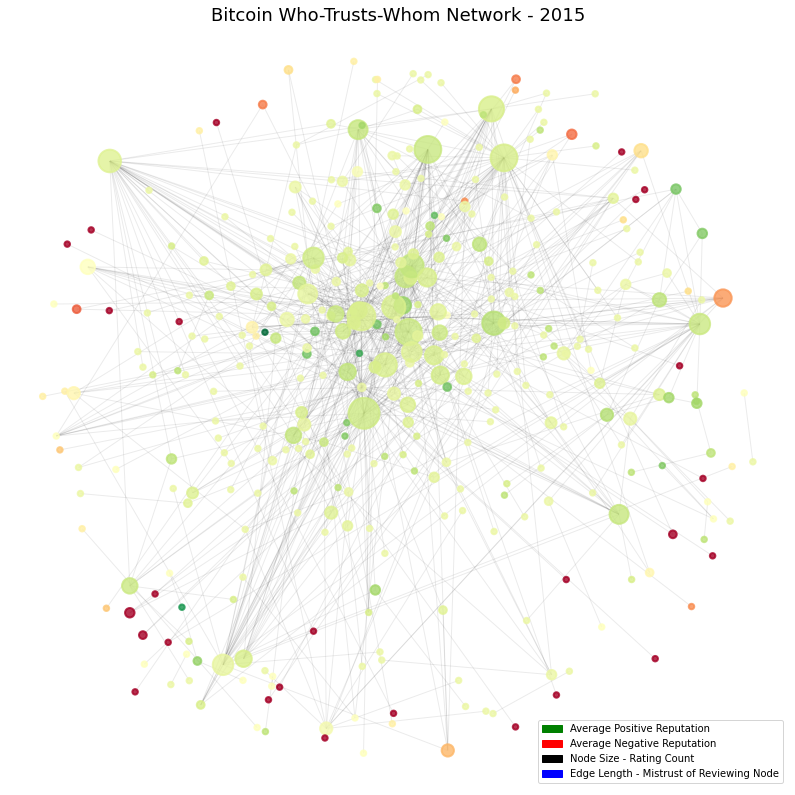

In [565]:
review_counts = tp1.groupby('target').rating.count()
average_reviews = tp1.groupby('target').rating.mean()
print(review_counts)
print(average_reviews)
def get_size(user_id, m=20, min=30):
    s = review_counts.get(user_id)
    if s is not None:
        return min * s
    else:
        return min

def get_color(user_id):
    s = average_reviews.get(user_id)
    if s is None:
        return 0.5
    # need a scaling function to translate -10-10 to 0.0-1.0 for colors maps
    return np.interp(s, (-10, 10), (0, 1))

plt.figure(figsize=(14, 14)) 
plt.title("Bitcoin Who-Trusts-Whom Network - 2015", fontsize=18)

untrusted = mpatches.Patch(color='red', label='Average Negative Reputation')
trusted = mpatches.Patch(color='green', label='Average Positive Reputation')
size = mpatches.Patch(color='black', label='Node Size - Rating Count')
edges = mpatches.Patch(color='blue', label='Edge Length - Mistrust of Reviewing Node')
plt.legend(handles=[trusted, untrusted, size, edges], loc='lower right')

pos = nx.spring_layout(G, k=0.25)
sizes = [get_size(n) for n in G]
colors = [get_color(n) for n in G]

nc = nx.draw_networkx_nodes(
    G, pos, nodelist=G.nodes(), node_size=sizes, linewidths=2.0,
    node_color=colors, cmap=plt.cm.RdYlGn, alpha=0.8
)
ec = nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.08)
ax = plt.axis('off')
plt.show()

[Text(0, 0, '49'),
 Text(0, 0, '41'),
 Text(0, 0, '36'),
 Text(0, 0, '35'),
 Text(0, 0, '31'),
 Text(0, 0, '28'),
 Text(0, 0, '27'),
 Text(0, 0, '26'),
 Text(0, 0, '25'),
 Text(0, 0, '23'),
 Text(0, 0, '20'),
 Text(0, 0, '19'),
 Text(0, 0, '18'),
 Text(0, 0, '17'),
 Text(0, 0, '16'),
 Text(0, 0, '15'),
 Text(0, 0, '14'),
 Text(0, 0, '13'),
 Text(0, 0, '12'),
 Text(0, 0, '11'),
 Text(0, 0, '10'),
 Text(0, 0, '9'),
 Text(0, 0, '8'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1')]

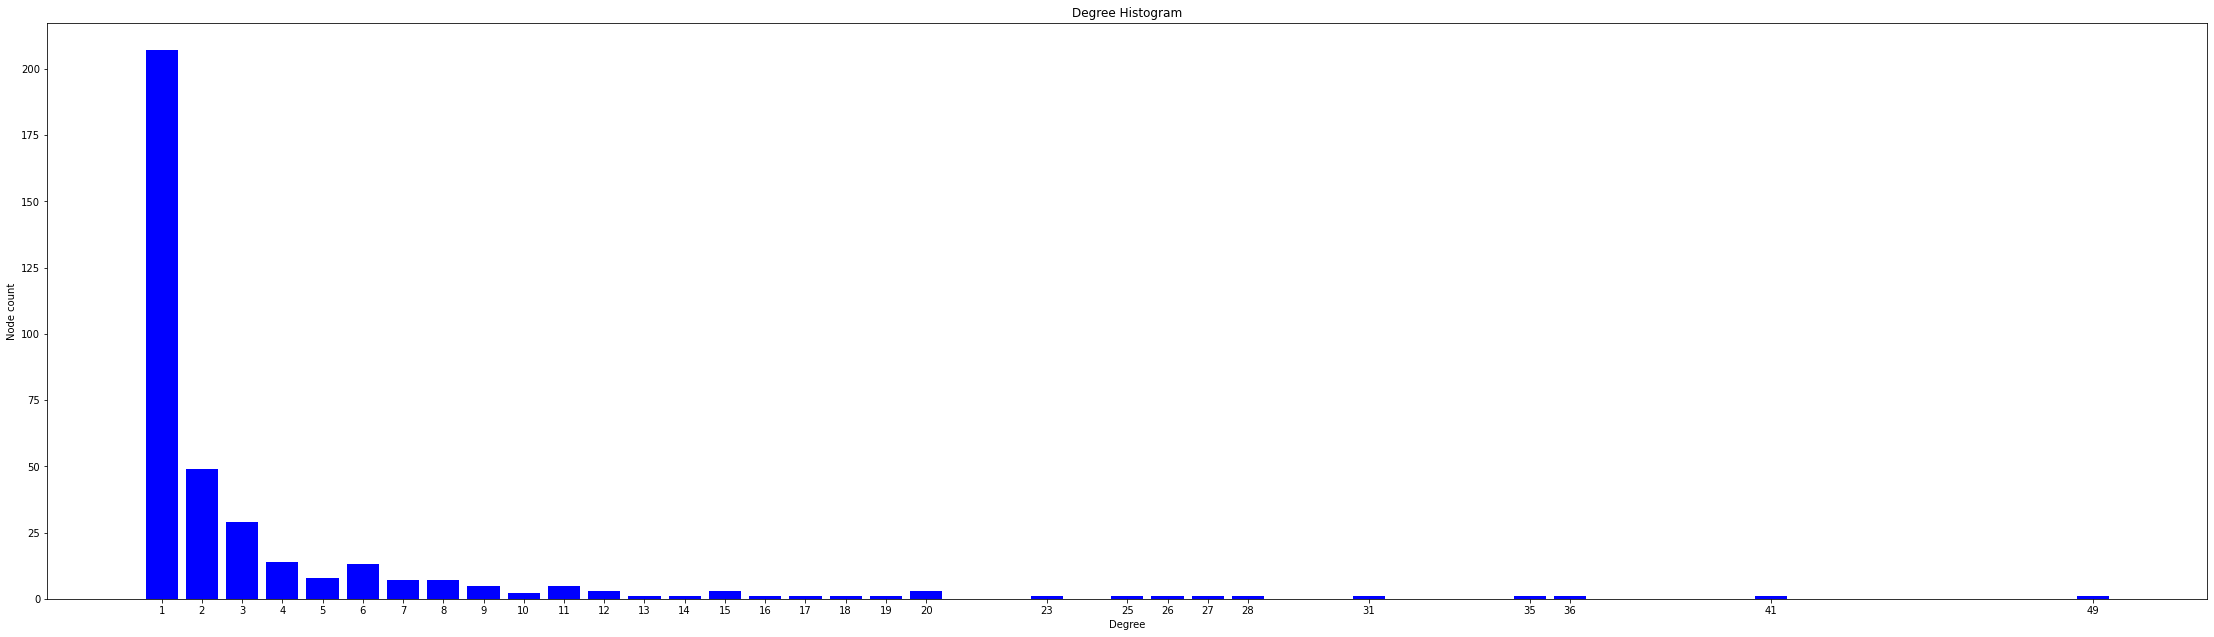

In [566]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
#plt.figure(figsize = (200, 100))
plt.subplots_adjust(left=0, right=5, bottom=0, top=2)
plt.bar(deg, cnt, width=0.8, color="b")
plt.title("Degree Histogram")
plt.ylabel("Node count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)

In [ ]:
l = []
for i in dataset.index:
    if(dataset['rating'][i]<0):
        l.append(dataset['source'][i])
#print(l)  

x = nx.closeness_centrality(G)
import operator
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_x[-20:]:
    closeness.append(i[0])
#print(closeness)    
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("closeness - fraudulent nodes :" , np.unique(common))      

y = nx.degree_centrality(G)
import operator
sorted_y = sorted(y.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_y[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("degree - fraudulent nodes :" , np.unique(common)) 

z = nx.betweenness_centrality(G)
import operator
sorted_z = sorted(z.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_z[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("betweeness - fraudulent nodes :" , np.unique(common)) 

a = nx.pagerank(G,max_iter=10000)
import operator
sorted_a = sorted(a.items(), key=operator.itemgetter(1))
common=[]
closeness=[]
for i in sorted_a[-20:]:
    closeness.append(i[0])
for k in closeness:
    for j in l:      
        if k==j:
            common.append(j)          
print("pagerank - fraudulent nodes :" , np.unique(common)) 


closeness - fraudulent nodes : [  35 1052 1810 2045 2063 2067 2388 2942 3345 3451 3598 3804 4197 4291
 4304 4532]
degree - fraudulent nodes : [  35 1018 1052 1810 2045 2067 2388 2942 3451 3598 3828 3878 4197 4205
 4291 4532 4649]
betweeness - fraudulent nodes : [  35 1052 1352 1810 2045 2067 2388 3345 3451 3598 3828 3878 4172 4205
 4291 4532 4649]


c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:154: RuntimeWarning: overflow encountered in double_scalars
  err = sum([abs(x[n] - xlast[n]) for n in x])
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: overflow encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:151: RuntimeWarning: invalid value encountered in double_scalars
  x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
c:\users\brsan\appdata\local\programs\python\python38-32\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:152: RuntimeWarning: invalid value encountered in double_scalars
  x[n] += danglesum * dangling_weights.get(n, 0) + (1.0 - alpha) * p.get(n, 0)


In [ ]:
# y = nx.degree_centrality(G)
# import operator
# sorted_y = sorted(y.items(), key=operator.itemgetter(1))
# print(sorted_y[-20:])

In [ ]:
# z = nx.betweenness_centrality(G)
# import operator
# sorted_z = sorted(z.items(), key=operator.itemgetter(1))
# print(sorted_z[-20:])

In [ ]:
# a = nx.pagerank(G,max_iter=10000)
# import operator
# sorted_a = sorted(a.items(), key=operator.itemgetter(1))
# print(sorted_a[-20:])

In [ ]:
# l = []
# for i in dataset.index:
#     if(dataset['rating'][i]<0):
#         l.append(dataset['source'][i])
# print(l)        


In [ ]:
# common=[]
# for i in sorted_x[-20:]:
#     for j in l:
#         if i==j:
#             common.append(j)
# print(common)            